In [3]:
# Teeth Classification Project
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

2025-07-04 15:06:19.720966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751641579.926195      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751641579.982816      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Initialize global variables
IMG_SIZE = (224, 224)  # Standard size for dental images
BATCH_SIZE = 32
NUM_CLASSES = 7  # As per project requirements
EPOCHS = 30

In [5]:
data_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
folds = os.listdir(data_dir)

filepath = []
class_names = []

for fold in folds:
    folderpath = os.path.join(data_dir, fold)
    files = os.listdir(folderpath)
    for file in files:
        filepath.append(os.path.join(folderpath,file))
        class_names.append(fold)
data = pd.DataFrame({'filepath':filepath, 'labels':class_names})


In [6]:
# Count number of images per class
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


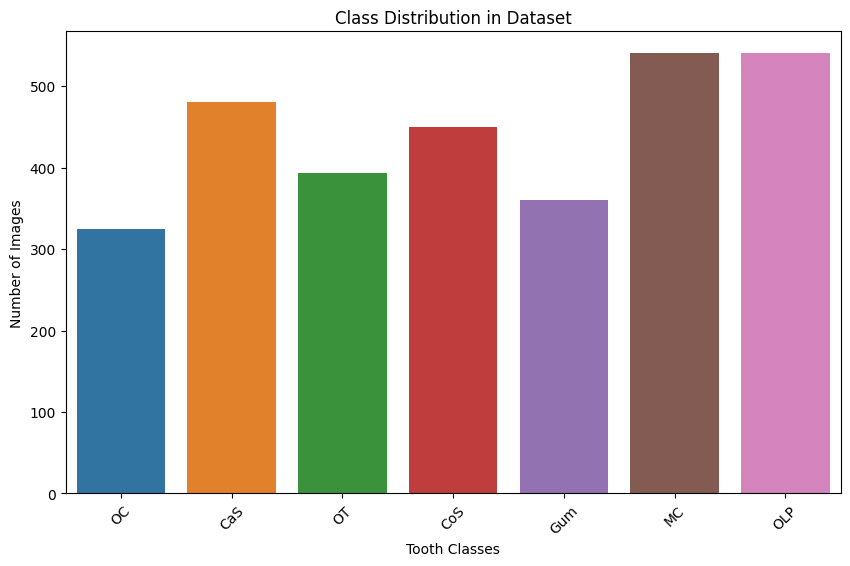

In [7]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Dataset')
plt.xlabel('Tooth Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

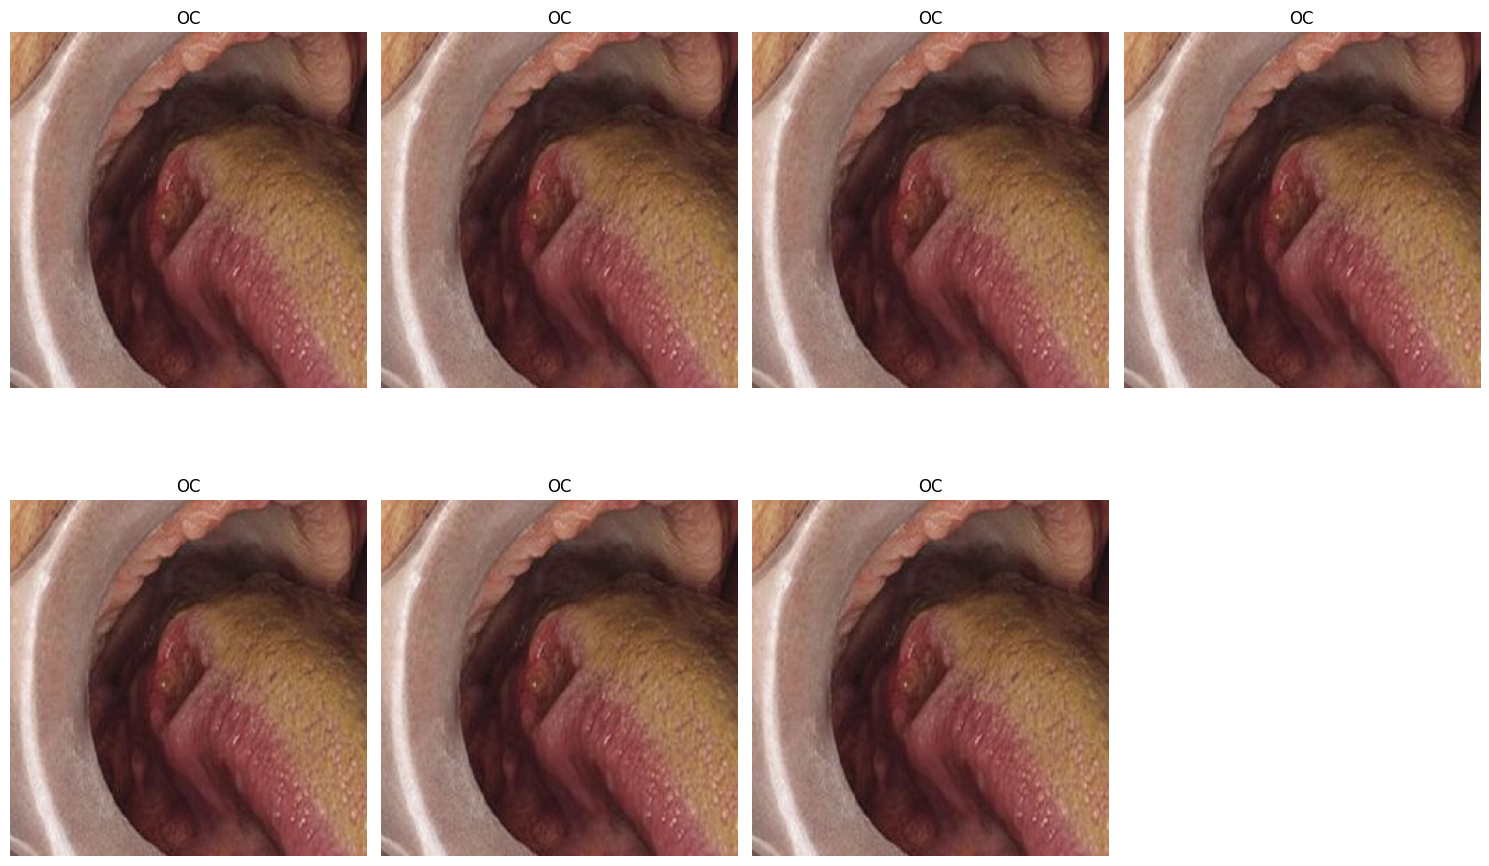

In [8]:

# Display sample images
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names[:7]):
    class_dir = os.path.join(data_dir, class_name)
    img_path = os.path.join(class_dir, os.listdir(class_dir)[0])
    img = Image.open(img_path)
    
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
# Data Preprocessing
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
# Create data flows
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2471 images belonging to 7 classes.
Found 616 images belonging to 7 classes.


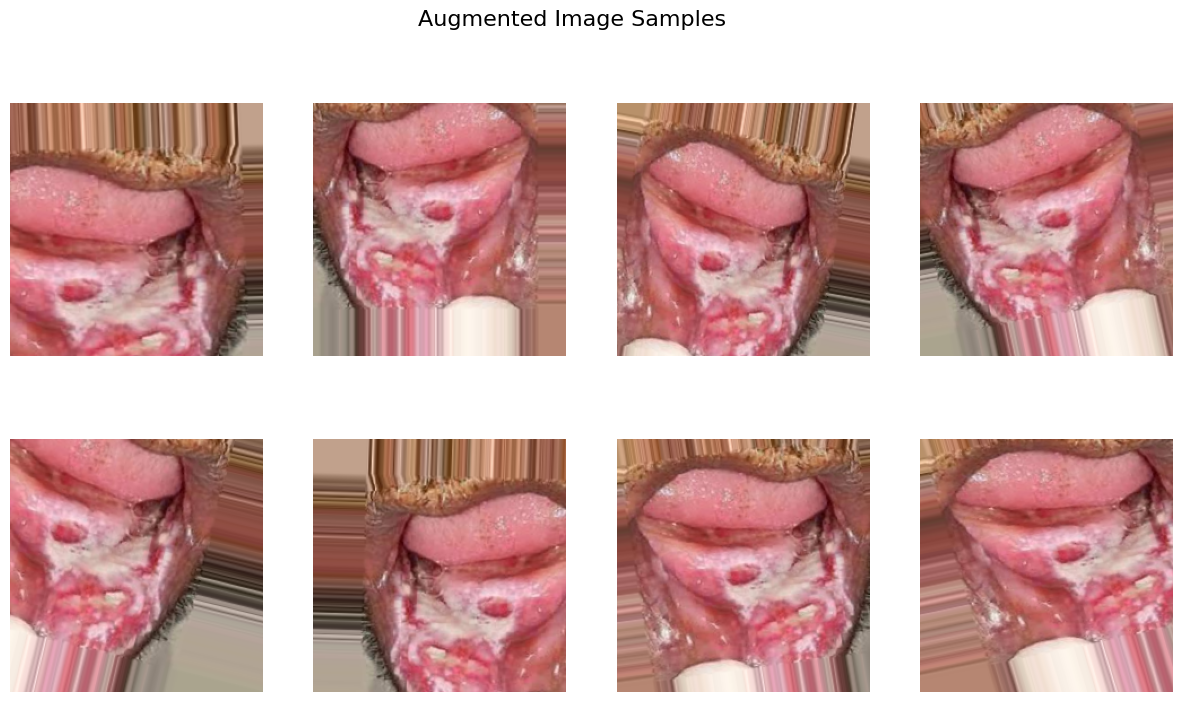

In [11]:
# Visualize augmented images
augmented_images = [train_generator[0][0][0] for i in range(8)]

plt.figure(figsize=(15, 8))
for i, img in enumerate(augmented_images):
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Augmented Image Samples', fontsize=16)
plt.show()


In [12]:
# Model Building
def create_model(input_shape=(224, 224, 3), num_classes=7):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751641600.891007      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,268,807 (73.50 MB)

 Trainable params: 19,267,847 (73.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
# Model Training
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1751641608.140033     113 service.cc:148] XLA service 0x7d7120003040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751641608.140985     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751641608.685580     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/77 ━━━━━━━━━━━━━━━━━━━━ 14:18 11s/step - accuracy: 0.0938 - loss: 4.2272

I0000 00:00:1751641614.266698     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 582ms/step - accuracy: 0.2373 - loss: 13.1242 - val_accuracy: 0.1480 - val_loss: 18.7914 - learning_rate: 0.0010
Epoch 2/30
 1/77 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2812 - loss: 3.3867

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.2812 - loss: 3.3867 - val_accuracy: 0.1480 - val_loss: 18.7558 - learning_rate: 0.0010
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 432ms/step - accuracy: 0.2863 - loss: 2.2482 - val_accuracy: 0.1480 - val_loss: 7.1553 - learning_rate: 0.0010
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.1562 - loss: 2.0975 - val_accuracy: 0.1480 - val_loss: 7.2059 - learning_rate: 0.0010
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 429ms/step - accuracy: 0.3134 - loss: 1.7942 - val_accuracy: 0.1480 - val_loss: 8.3985 - learning_rate: 0.0010
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.2812 - loss: 1.6514 - val_accuracy: 0.1480 - val_loss: 8.3464 - learning_rate: 0.0010
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 436ms/step - accuracy: 0.3256 - loss: 1.6948 - val_accuracy: 0.1661 - val_loss: 7.3503 - learning_rate: 2.0000e-04
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.3750 - loss: 1.5834 - val_acc

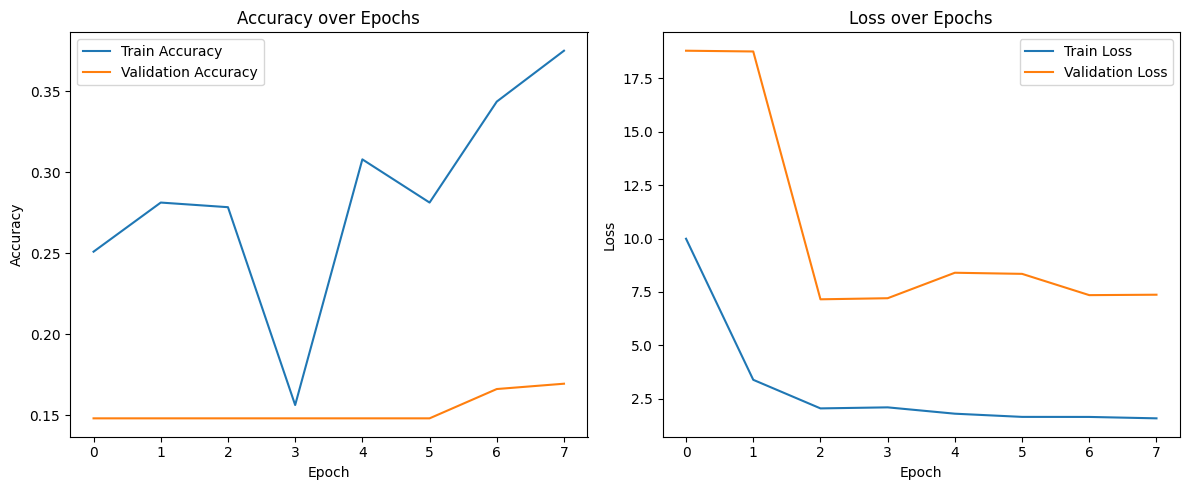

In [14]:
# Model Evaluation
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - accuracy: 0.2142 - loss: 6.0570
Validation Accuracy: 14.61%
Validation Loss: 7.2042


In [16]:
# Save the model
model.save('teeth_classification_model.keras')